In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import torch
from Models.models import NNdynamicMulti, plot_confusion_matrix, plot_metrics
from imblearn.over_sampling import SMOTE

In [22]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_19372\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [23]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [24]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [25]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [26]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [27]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [28]:
X_temp = data.drop(columns=['label', 'attack_cat'])
y = data['attack_cat']
attack_cat = data['attack_cat']
le = LabelEncoder()
y = le.fit_transform(y)
y = pd.Series(y)
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)

In [29]:
print(y_test.value_counts())

6    443831
5     43110
3      8732
4      4784
2      3315
7      2850
0       550
1       477
8       320
9        41
Name: count, dtype: int64


In [30]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch 1/5: 100%|██████████| 15876/15876 [01:49<00:00, 144.69batch/s]


Epoch [1/5], Train Loss: 0.0773, Train Acc: 0.9733, Train F1: 0.9699


Epoch 2/5: 100%|██████████| 15876/15876 [01:45<00:00, 150.98batch/s]


Epoch [2/5], Train Loss: 0.0763, Train Acc: 0.9738, Train F1: 0.9704


Epoch 3/5: 100%|██████████| 15876/15876 [01:45<00:00, 150.17batch/s]


Epoch [3/5], Train Loss: 0.0804, Train Acc: 0.9720, Train F1: 0.9692


Epoch 4/5: 100%|██████████| 15876/15876 [01:46<00:00, 149.37batch/s]


Epoch [4/5], Train Loss: 0.0761, Train Acc: 0.9736, Train F1: 0.9702


Epoch 5/5: 100%|██████████| 15876/15876 [01:49<00:00, 144.77batch/s]


Epoch [5/5], Train Loss: 0.0905, Train Acc: 0.9661, Train F1: 0.9640


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 327.49batch/s]


Test Loss: 0.0929, Test Accuracy: 0.9647, Test F1: 0.9650


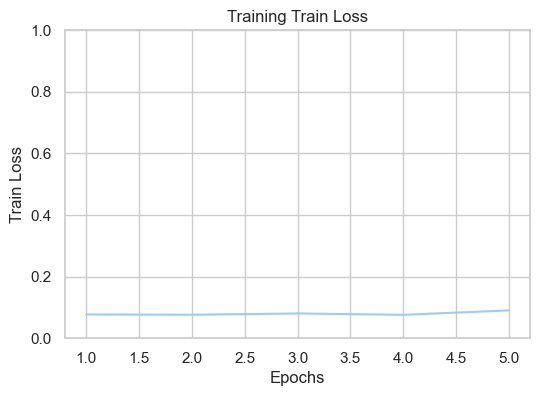

Standard Test


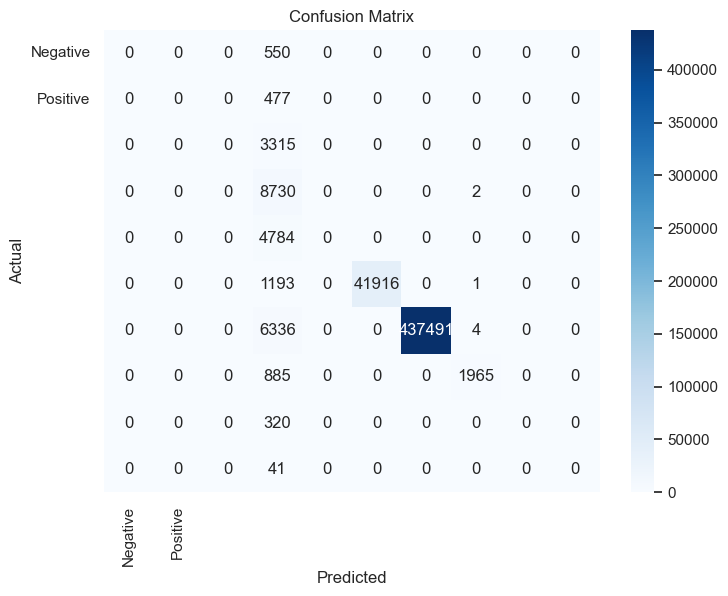

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/multi/01'
model1 = NNdynamicMulti(n_features, fc_size, device, save_dir)
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.1
epochs = 5
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

In [33]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/02/multi/01/PB_epoch_{i}.pth"
    model1.load_model(path)
    print(f"Epoch: {i}")
    model1.test(test_loader)
    unique_classes = np.unique(y_test)
    preds = model1.test_predicted
    for cls in unique_classes:
        actual_class = y_test == cls
        predicted_class = preds == cls
        class_accuracy = np.sum(actual_class & predicted_class) / np.sum(actual_class)
        print(f"{cls}': {class_accuracy:.4f}")

Epoch: 1


Testing:   0%|          | 0/3969 [00:00<?, ?batch/s]

Testing: 100%|██████████| 3969/3969 [00:12<00:00, 328.66batch/s]


Test Loss: 0.0746, Test Accuracy: 0.9716, Test F1: 0.9734
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.9923
4': 0.7715
5': 0.9723
6': 0.9854
7': 0.6874
8': 0.0000


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


9': 0.0000
Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 326.42batch/s]


Test Loss: 0.0711, Test Accuracy: 0.9747, Test F1: 0.9690
0': 0.0000
1': 0.0000
2': 0.0006
3': 0.9971
4': 0.0000
5': 0.9723
6': 0.9973


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.6726
8': 0.0000
9': 0.0000
Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 327.98batch/s]


Test Loss: 0.0711, Test Accuracy: 0.9751, Test F1: 0.9719
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.9977
4': 0.2343
5': 0.9723
6': 0.9951


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.6916
8': 0.0000
9': 0.0000
Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 328.21batch/s]


Test Loss: 0.0718, Test Accuracy: 0.9748, Test F1: 0.9692
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.9986
4': 0.0000
5': 0.9723
6': 0.9972
7': 0.6884


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.0000
9': 0.0000
Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 334.73batch/s]


Test Loss: 0.0929, Test Accuracy: 0.9647, Test F1: 0.9650
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.9998
4': 0.0000
5': 0.9723
6': 0.9857
7': 0.6895
8': 0.0000
9': 0.0000


Epoch 1/30: 100%|██████████| 15876/15876 [01:41<00:00, 156.94batch/s]


Epoch [1/30], Train Loss: 0.0588, Train Acc: 0.9781, Train F1: 0.9756


Epoch 2/30: 100%|██████████| 15876/15876 [01:38<00:00, 161.97batch/s]


Epoch [2/30], Train Loss: 0.0492, Train Acc: 0.9802, Train F1: 0.9783


Epoch 3/30: 100%|██████████| 15876/15876 [01:41<00:00, 156.95batch/s]


Epoch [3/30], Train Loss: 0.0481, Train Acc: 0.9806, Train F1: 0.9788


Epoch 4/30: 100%|██████████| 15876/15876 [01:43<00:00, 153.21batch/s]


Epoch [4/30], Train Loss: 0.0474, Train Acc: 0.9809, Train F1: 0.9792


Epoch 5/30: 100%|██████████| 15876/15876 [01:45<00:00, 150.75batch/s]


Epoch [5/30], Train Loss: 0.0470, Train Acc: 0.9811, Train F1: 0.9794


Epoch 6/30: 100%|██████████| 15876/15876 [01:47<00:00, 148.25batch/s]


Epoch [6/30], Train Loss: 0.0465, Train Acc: 0.9812, Train F1: 0.9796


Epoch 7/30: 100%|██████████| 15876/15876 [01:49<00:00, 145.17batch/s]


Epoch [7/30], Train Loss: 0.0462, Train Acc: 0.9813, Train F1: 0.9797


Epoch 8/30: 100%|██████████| 15876/15876 [01:50<00:00, 144.11batch/s]


Epoch [8/30], Train Loss: 0.0459, Train Acc: 0.9814, Train F1: 0.9799


Epoch 9/30: 100%|██████████| 15876/15876 [01:53<00:00, 140.05batch/s]


Epoch [9/30], Train Loss: 0.0457, Train Acc: 0.9815, Train F1: 0.9801


Epoch 10/30: 100%|██████████| 15876/15876 [01:57<00:00, 135.36batch/s]


Epoch [10/30], Train Loss: 0.0456, Train Acc: 0.9815, Train F1: 0.9800


Epoch 11/30: 100%|██████████| 15876/15876 [01:57<00:00, 134.71batch/s]


Epoch [11/30], Train Loss: 0.0454, Train Acc: 0.9816, Train F1: 0.9802


Epoch 12/30: 100%|██████████| 15876/15876 [01:55<00:00, 137.53batch/s]


Epoch [12/30], Train Loss: 0.0452, Train Acc: 0.9817, Train F1: 0.9802


Epoch 13/30: 100%|██████████| 15876/15876 [01:54<00:00, 138.20batch/s]


Epoch [13/30], Train Loss: 0.0450, Train Acc: 0.9817, Train F1: 0.9803


Epoch 14/30: 100%|██████████| 15876/15876 [01:56<00:00, 136.33batch/s]


Epoch [14/30], Train Loss: 0.0450, Train Acc: 0.9818, Train F1: 0.9804


Epoch 15/30: 100%|██████████| 15876/15876 [01:56<00:00, 136.33batch/s]


Epoch [15/30], Train Loss: 0.0448, Train Acc: 0.9818, Train F1: 0.9803


Epoch 16/30: 100%|██████████| 15876/15876 [01:57<00:00, 134.97batch/s]


Epoch [16/30], Train Loss: 0.0448, Train Acc: 0.9818, Train F1: 0.9804


Epoch 17/30: 100%|██████████| 15876/15876 [01:57<00:00, 135.34batch/s]


Epoch [17/30], Train Loss: 0.0447, Train Acc: 0.9819, Train F1: 0.9806


Epoch 18/30: 100%|██████████| 15876/15876 [01:57<00:00, 134.83batch/s]


Epoch [18/30], Train Loss: 0.0445, Train Acc: 0.9819, Train F1: 0.9805


Epoch 19/30: 100%|██████████| 15876/15876 [01:56<00:00, 136.66batch/s]


Epoch [19/30], Train Loss: 0.0445, Train Acc: 0.9820, Train F1: 0.9806


Epoch 20/30: 100%|██████████| 15876/15876 [01:56<00:00, 136.03batch/s]


Epoch [20/30], Train Loss: 0.0444, Train Acc: 0.9820, Train F1: 0.9806


Epoch 21/30: 100%|██████████| 15876/15876 [01:55<00:00, 137.29batch/s]


Epoch [21/30], Train Loss: 0.0443, Train Acc: 0.9820, Train F1: 0.9807


Epoch 22/30: 100%|██████████| 15876/15876 [01:56<00:00, 136.31batch/s]


Epoch [22/30], Train Loss: 0.0442, Train Acc: 0.9820, Train F1: 0.9807


Epoch 23/30: 100%|██████████| 15876/15876 [01:56<00:00, 136.19batch/s]


Epoch [23/30], Train Loss: 0.0442, Train Acc: 0.9821, Train F1: 0.9808


Epoch 24/30: 100%|██████████| 15876/15876 [01:56<00:00, 136.05batch/s]


Epoch [24/30], Train Loss: 0.0441, Train Acc: 0.9821, Train F1: 0.9808


Epoch 25/30: 100%|██████████| 15876/15876 [01:56<00:00, 136.03batch/s]


Epoch [25/30], Train Loss: 0.0440, Train Acc: 0.9822, Train F1: 0.9808


Epoch 26/30: 100%|██████████| 15876/15876 [01:57<00:00, 135.06batch/s]


Epoch [26/30], Train Loss: 0.0439, Train Acc: 0.9822, Train F1: 0.9809


Epoch 27/30: 100%|██████████| 15876/15876 [01:58<00:00, 134.51batch/s]


Epoch [27/30], Train Loss: 0.0439, Train Acc: 0.9822, Train F1: 0.9809


Epoch 28/30: 100%|██████████| 15876/15876 [01:59<00:00, 132.87batch/s]


Epoch [28/30], Train Loss: 0.0439, Train Acc: 0.9822, Train F1: 0.9810


Epoch 29/30: 100%|██████████| 15876/15876 [01:59<00:00, 133.07batch/s]


Epoch [29/30], Train Loss: 0.0439, Train Acc: 0.9822, Train F1: 0.9810


Epoch 30/30: 100%|██████████| 15876/15876 [01:58<00:00, 133.49batch/s]


Epoch [30/30], Train Loss: 0.0438, Train Acc: 0.9822, Train F1: 0.9809


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 337.79batch/s]

Test Loss: 0.0466, Test Accuracy: 0.9813, Test F1: 0.9795


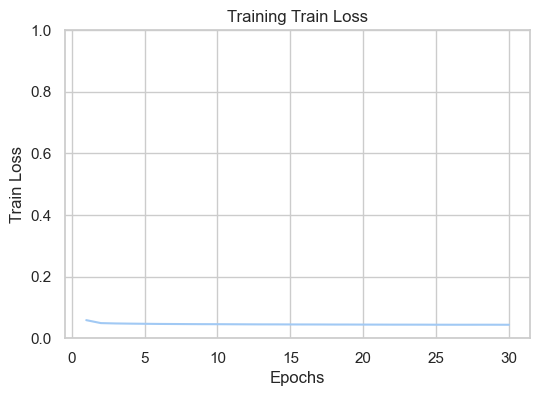

Standard Test


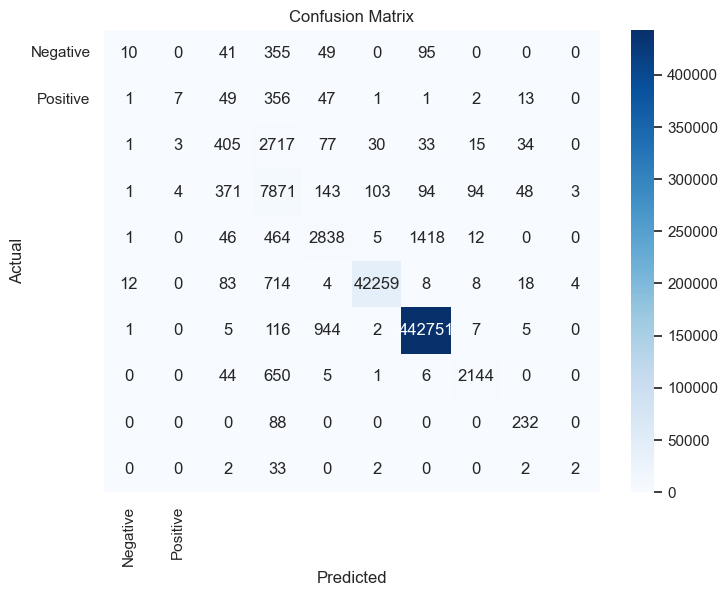

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/multi/0001'
model1 = NNdynamicMulti(n_features, fc_size, device, save_dir)
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.001
epochs = 30
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

In [35]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/02/multi/0001/PB_epoch_{i}.pth"
    model1.load_model(path)
    print(f"Epoch: {i}")
    model1.test(test_loader)
    unique_classes = np.unique(y_test)
    preds = model1.test_predicted
    for cls in unique_classes:
        actual_class = y_test == cls
        predicted_class = preds == cls
        class_accuracy = np.sum(actual_class & predicted_class) / np.sum(actual_class)
        print(f"{cls}': {class_accuracy:.4f}")

c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 335.39batch/s]


Test Loss: 0.0507, Test Accuracy: 0.9795, Test F1: 0.9782
0': 0.0109
1': 0.0021
2': 0.2995
3': 0.7651
4': 0.4998
5': 0.9797
6': 0.9977
7': 0.7926


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.7406
9': 0.0000
Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 337.70batch/s]


Test Loss: 0.0490, Test Accuracy: 0.9802, Test F1: 0.9771
0': 0.0255
1': 0.0021
2': 0.0241
3': 0.9342
4': 0.4827
5': 0.9785
6': 0.9982


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.6989
8': 0.5375
9': 0.0000
Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 331.44batch/s]


Test Loss: 0.0482, Test Accuracy: 0.9805, Test F1: 0.9774
0': 0.0164
1': 0.0084
2': 0.0199
3': 0.9627
4': 0.4914
5': 0.9790
6': 0.9979
7': 0.7112


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.4969
9': 0.0000
Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 332.32batch/s]


Test Loss: 0.0483, Test Accuracy: 0.9808, Test F1: 0.9797
0': 0.0236
1': 0.0189
2': 0.2238
3': 0.8835
4': 0.6298
5': 0.9767
6': 0.9969


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.7004
8': 0.5281
9': 0.0000
Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 332.69batch/s]


Test Loss: 0.0472, Test Accuracy: 0.9808, Test F1: 0.9799
0': 0.0145
1': 0.0231
2': 0.2992
3': 0.8263
4': 0.5909
5': 0.9795
6': 0.9974
7': 0.7295


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.6594
9': 0.0000
Epoch: 6


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 333.86batch/s]


Test Loss: 0.0476, Test Accuracy: 0.9808, Test F1: 0.9804
0': 0.0273
1': 0.0147
2': 0.2869
3': 0.7971
4': 0.6453
5': 0.9788
6': 0.9968


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.8365
8': 0.7344
9': 0.0000
Epoch: 7


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 333.96batch/s]


Test Loss: 0.0475, Test Accuracy: 0.9809, Test F1: 0.9793
0': 0.0182
1': 0.0210
2': 0.2736
3': 0.8265
4': 0.4889
5': 0.9786
6': 0.9984
7': 0.7884


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.8531
9': 0.0244
Epoch: 8


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 329.18batch/s]


Test Loss: 0.0470, Test Accuracy: 0.9808, Test F1: 0.9782
0': 0.0109
1': 0.0063
2': 0.0899
3': 0.9137
4': 0.5023
5': 0.9806
6': 0.9983
7': 0.7067


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.7312
9': 0.0244
Epoch: 9


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 329.60batch/s]


Test Loss: 0.0468, Test Accuracy: 0.9811, Test F1: 0.9786
0': 0.0145
1': 0.0147
2': 0.0540
3': 0.9335
4': 0.5353
5': 0.9789
6': 0.9980
7': 0.7449


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.7656
9': 0.0488
Epoch: 10


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 336.93batch/s]


Test Loss: 0.0468, Test Accuracy: 0.9812, Test F1: 0.9801
0': 0.0200
1': 0.0252
2': 0.3279
3': 0.8187
4': 0.5648
5': 0.9796
6': 0.9980
7': 0.7312


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.7594
9': 0.0244
Epoch: 11


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 337.21batch/s]


Test Loss: 0.0468, Test Accuracy: 0.9812, Test F1: 0.9797
0': 0.0145
1': 0.0168
2': 0.1566
3': 0.8469
4': 0.5941
5': 0.9802
6': 0.9977
7': 0.8109


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.9375
9': 0.0000
Epoch: 12


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 337.73batch/s]


Test Loss: 0.0466, Test Accuracy: 0.9811, Test F1: 0.9799
0': 0.0145
1': 0.0063
2': 0.2353
3': 0.8729
4': 0.5932
5': 0.9793
6': 0.9974


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.7175
8': 0.7344
9': 0.0000
Epoch: 13


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 335.55batch/s]


Test Loss: 0.0468, Test Accuracy: 0.9811, Test F1: 0.9802
0': 0.0200
1': 0.0063
2': 0.3644
3': 0.8084
4': 0.5245
5': 0.9795
6': 0.9978


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.7958
8': 0.7719
9': 0.0244
Epoch: 14


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 338.85batch/s]


Test Loss: 0.0466, Test Accuracy: 0.9810, Test F1: 0.9789
0': 0.0145
1': 0.0084
2': 0.1469
3': 0.8790
4': 0.5581
5': 0.9807
6': 0.9981


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.7067
8': 0.6250
9': 0.0244
Epoch: 15


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 333.09batch/s]


Test Loss: 0.0468, Test Accuracy: 0.9811, Test F1: 0.9808
0': 0.0218
1': 0.0105
2': 0.3991
3': 0.8109
4': 0.6164
5': 0.9791
6': 0.9971
7': 0.7309


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.6813
9': 0.0488
Epoch: 16


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 327.50batch/s]


Test Loss: 0.0465, Test Accuracy: 0.9812, Test F1: 0.9799
0': 0.0164
1': 0.0168
2': 0.2151
3': 0.8502
4': 0.5884
5': 0.9797
6': 0.9979
7': 0.7295


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.9125
9': 0.0244
Epoch: 17


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 328.88batch/s]


Test Loss: 0.0470, Test Accuracy: 0.9811, Test F1: 0.9802
0': 0.0291
1': 0.0042
2': 0.3252
3': 0.8266
4': 0.5995
5': 0.9802
6': 0.9976
7': 0.7088


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.6188
9': 0.0244
Epoch: 18


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 330.04batch/s]


Test Loss: 0.0469, Test Accuracy: 0.9811, Test F1: 0.9806
0': 0.0382
1': 0.0314
2': 0.3128
3': 0.8317
4': 0.6120
5': 0.9797
6': 0.9969
7': 0.7639


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.8812
9': 0.0244
Epoch: 19


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 334.11batch/s]


Test Loss: 0.0466, Test Accuracy: 0.9812, Test F1: 0.9803
0': 0.0164
1': 0.0273
2': 0.3403
3': 0.8241
4': 0.5594
5': 0.9793
6': 0.9978


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.7495
8': 0.7562
9': 0.0244
Epoch: 20


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 335.32batch/s]


Test Loss: 0.0465, Test Accuracy: 0.9811, Test F1: 0.9799
0': 0.0364
1': 0.0168
2': 0.2543
3': 0.8534
4': 0.5734
5': 0.9811
6': 0.9977


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.7042
8': 0.8156
9': 0.0244
Epoch: 21


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 338.33batch/s]


Test Loss: 0.0466, Test Accuracy: 0.9812, Test F1: 0.9801
0': 0.0345
1': 0.0294
2': 0.2703
3': 0.8219
4': 0.5579
5': 0.9794
6': 0.9980
7': 0.8014


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.7719
9': 0.0244
Epoch: 22


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 336.96batch/s]


Test Loss: 0.0462, Test Accuracy: 0.9814, Test F1: 0.9807
0': 0.0236
1': 0.0398
2': 0.3149
3': 0.8200
4': 0.6148
5': 0.9810
6': 0.9973
7': 0.7698


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.8219
9': 0.0244
Epoch: 23


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 326.47batch/s]


Test Loss: 0.0464, Test Accuracy: 0.9814, Test F1: 0.9801
0': 0.0145
1': 0.0210
2': 0.2184
3': 0.8665
4': 0.6018
5': 0.9810
6': 0.9975
7': 0.7554


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.6250
9': 0.0244
Epoch: 24


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 331.85batch/s]


Test Loss: 0.0467, Test Accuracy: 0.9811, Test F1: 0.9793
0': 0.0309
1': 0.0252
2': 0.0787
3': 0.9148
4': 0.6309
5': 0.9817
6': 0.9971
7': 0.7077


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.7875
9': 0.0244
Epoch: 25


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 335.57batch/s]


Test Loss: 0.0466, Test Accuracy: 0.9813, Test F1: 0.9800
0': 0.0218
1': 0.0147
2': 0.2136
3': 0.8851
4': 0.5995
5': 0.9802
6': 0.9973


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.7168
8': 0.7937
9': 0.0244
Epoch: 26


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 332.86batch/s]


Test Loss: 0.0466, Test Accuracy: 0.9813, Test F1: 0.9804
0': 0.0055
1': 0.0231
2': 0.3143
3': 0.8227
4': 0.5832
5': 0.9815
6': 0.9977
7': 0.7404


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.8625
9': 0.0000
Epoch: 27


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 331.65batch/s]


Test Loss: 0.0470, Test Accuracy: 0.9813, Test F1: 0.9802
0': 0.0164
1': 0.0147
2': 0.3189
3': 0.8266
4': 0.5742
5': 0.9799
6': 0.9979


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.7393
8': 0.6500
9': 0.0244
Epoch: 28


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 327.17batch/s]


Test Loss: 0.0469, Test Accuracy: 0.9810, Test F1: 0.9787
0': 0.0327
1': 0.0231
2': 0.0778
3': 0.9269
4': 0.5370
5': 0.9805
6': 0.9979
7': 0.7112


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.6844
9': 0.0000
Epoch: 29


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 329.71batch/s]


Test Loss: 0.0468, Test Accuracy: 0.9814, Test F1: 0.9791
0': 0.0164
1': 0.0231
2': 0.0480
3': 0.9298
4': 0.5830
5': 0.9797
6': 0.9977
7': 0.7698


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.6469
9': 0.0244
Epoch: 30


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 335.50batch/s]


Test Loss: 0.0466, Test Accuracy: 0.9813, Test F1: 0.9795
0': 0.0182
1': 0.0147
2': 0.1222
3': 0.9014
4': 0.5932
5': 0.9803
6': 0.9976
7': 0.7523
8': 0.7250
9': 0.0488


Epoch 1/5: 100%|██████████| 15876/15876 [01:43<00:00, 153.48batch/s]


Epoch [1/5], Train Loss: 0.2155, Train Acc: 0.9430, Train F1: 0.9312


Epoch 2/5: 100%|██████████| 15876/15876 [01:41<00:00, 155.83batch/s]


Epoch [2/5], Train Loss: 0.2078, Train Acc: 0.9414, Train F1: 0.9286


Epoch 3/5: 100%|██████████| 15876/15876 [01:42<00:00, 155.07batch/s]


Epoch [3/5], Train Loss: 0.2068, Train Acc: 0.9416, Train F1: 0.9287


Epoch 4/5: 100%|██████████| 15876/15876 [01:45<00:00, 150.83batch/s]


Epoch [4/5], Train Loss: 0.2066, Train Acc: 0.9414, Train F1: 0.9285


Epoch 5/5: 100%|██████████| 15876/15876 [01:44<00:00, 151.59batch/s]


Epoch [5/5], Train Loss: 0.2063, Train Acc: 0.9415, Train F1: 0.9287


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 334.29batch/s]

Test Loss: 0.2033, Test Accuracy: 0.9425, Test F1: 0.9299


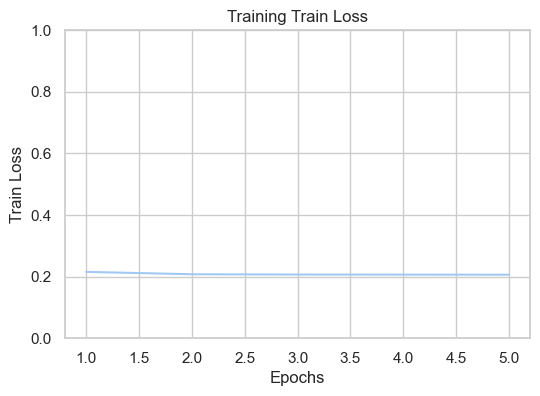

Standard Test


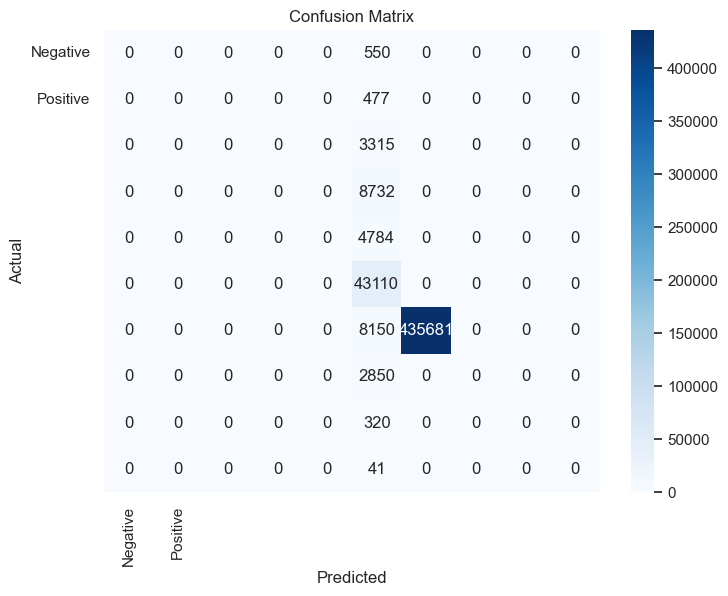

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/multi/07'
model1 = NNdynamicMulti(n_features, fc_size, device, save_dir)
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.7
epochs = 5
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

In [37]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/02/multi/07/PB_epoch_{i}.pth"
    model1.load_model(path)
    print(f"Epoch: {i}")
    model1.test(test_loader)
    unique_classes = np.unique(y_test)
    preds = model1.test_predicted
    for cls in unique_classes:
        actual_class = y_test == cls
        predicted_class = preds == cls
        class_accuracy = np.sum(actual_class & predicted_class) / np.sum(actual_class)
        print(f"{cls}': {class_accuracy:.4f}")

c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 331.79batch/s]


Test Loss: 0.1965, Test Accuracy: 0.9426, Test F1: 0.9300
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.0000
4': 0.0000
5': 1.0000
6': 0.9818
7': 0.0000


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.0000
9': 0.0000
Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 332.16batch/s]


Test Loss: 0.2423, Test Accuracy: 0.9425, Test F1: 0.9299
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.0000
4': 0.0000
5': 1.0000
6': 0.9816
7': 0.0000


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.0000
9': 0.0000
Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 335.76batch/s]


Test Loss: 0.2105, Test Accuracy: 0.9425, Test F1: 0.9299
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.0000
4': 0.0000
5': 1.0000
6': 0.9816


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.0000
8': 0.0000
9': 0.0000
Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 339.46batch/s]


Test Loss: 0.2026, Test Accuracy: 0.9425, Test F1: 0.9299
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.0000
4': 0.0000
5': 1.0000
6': 0.9816


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.0000
8': 0.0000
9': 0.0000
Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 335.25batch/s]


Test Loss: 0.2033, Test Accuracy: 0.9425, Test F1: 0.9299
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.0000
4': 0.0000
5': 1.0000
6': 0.9816
7': 0.0000
8': 0.0000
9': 0.0000


Epoch 1/5: 100%|██████████| 15876/15876 [04:08<00:00, 63.90batch/s]


Epoch [1/5], Train Loss: 0.1239, Train Acc: 0.9656, Train F1: 0.9604


Epoch 2/5: 100%|██████████| 15876/15876 [04:11<00:00, 63.02batch/s]


Epoch [2/5], Train Loss: 0.0872, Train Acc: 0.9670, Train F1: 0.9618


Epoch 3/5: 100%|██████████| 15876/15876 [04:07<00:00, 64.09batch/s]


Epoch [3/5], Train Loss: 0.0871, Train Acc: 0.9671, Train F1: 0.9619


Epoch 4/5: 100%|██████████| 15876/15876 [04:08<00:00, 63.96batch/s]


Epoch [4/5], Train Loss: 0.0871, Train Acc: 0.9671, Train F1: 0.9619


Epoch 5/5: 100%|██████████| 15876/15876 [04:10<00:00, 63.50batch/s]


Epoch [5/5], Train Loss: 0.0871, Train Acc: 0.9669, Train F1: 0.9617


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 326.77batch/s]

Test Loss: 0.1185, Test Accuracy: 0.9562, Test F1: 0.9360


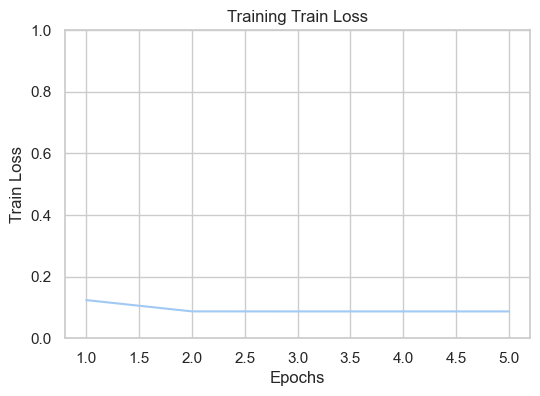

Standard Test


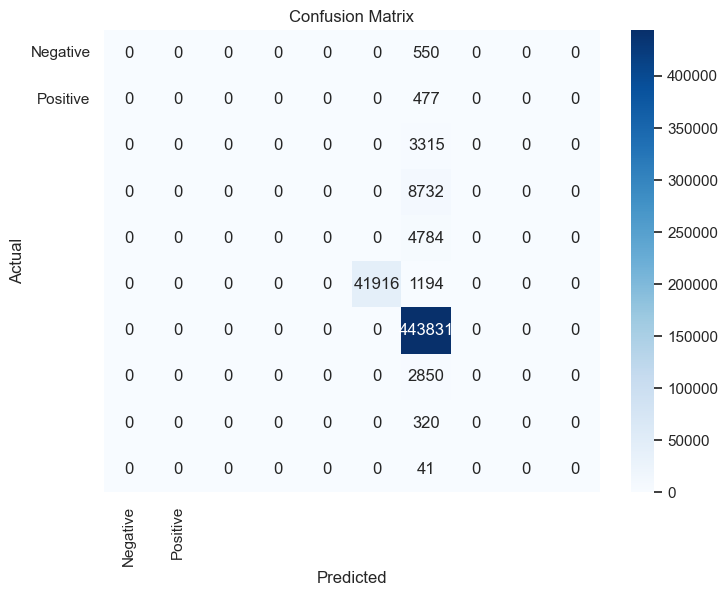

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/multi/tomeks07'
model1 = NNdynamicMulti(n_features, fc_size, device, save_dir)
sampler = 'tomeks'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.7
epochs = 5
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

In [39]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/02/multi/tomeks07/PB_epoch_{i}.pth"
    model1.load_model(path)
    print(f"Epoch: {i}")
    model1.test(test_loader)
    unique_classes = np.unique(y_test)
    preds = model1.test_predicted
    for cls in unique_classes:
        actual_class = y_test == cls
        predicted_class = preds == cls
        class_accuracy = np.sum(actual_class & predicted_class) / np.sum(actual_class)
        print(f"{cls}': {class_accuracy:.4f}")

c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 334.60batch/s]


Test Loss: 0.1373, Test Accuracy: 0.9548, Test F1: 0.9567
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.9998
4': 0.0000
5': 0.9426
6': 0.9816


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.0000
8': 0.0000
9': 0.0000
Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 339.04batch/s]


Test Loss: 0.1157, Test Accuracy: 0.9495, Test F1: 0.9530
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.0000
4': 1.0000
5': 0.9723
6': 0.9816


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


7': 0.0000
8': 0.0000
9': 0.0000
Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 336.46batch/s]


Test Loss: 0.1138, Test Accuracy: 0.9562, Test F1: 0.9360
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.0000
4': 0.0000
5': 0.9723
6': 1.0000
7': 0.0000


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.0000
9': 0.0000
Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 331.40batch/s]


Test Loss: 0.1179, Test Accuracy: 0.9562, Test F1: 0.9360
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.0000
4': 0.0000
5': 0.9723
6': 1.0000
7': 0.0000
8': 0.0000


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


9': 0.0000
Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 333.39batch/s]


Test Loss: 0.1185, Test Accuracy: 0.9562, Test F1: 0.9360
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.0000
4': 0.0000
5': 0.9723
6': 1.0000
7': 0.0000
8': 0.0000
9': 0.0000


Epoch 1/5: 100%|██████████| 15876/15876 [04:11<00:00, 63.22batch/s]


Epoch [1/5], Train Loss: 0.1154, Train Acc: 0.9665, Train F1: 0.9612


Epoch 2/5: 100%|██████████| 15876/15876 [04:09<00:00, 63.74batch/s]


Epoch [2/5], Train Loss: 0.0871, Train Acc: 0.9671, Train F1: 0.9618


Epoch 3/5: 100%|██████████| 15876/15876 [04:08<00:00, 63.89batch/s]


Epoch [3/5], Train Loss: 0.0914, Train Acc: 0.9668, Train F1: 0.9614


Epoch 4/5: 100%|██████████| 15876/15876 [04:11<00:00, 63.19batch/s]


Epoch [4/5], Train Loss: 0.1020, Train Acc: 0.9663, Train F1: 0.9610


Epoch 5/5: 100%|██████████| 15876/15876 [04:13<00:00, 62.63batch/s]


Epoch [5/5], Train Loss: 0.0874, Train Acc: 0.9672, Train F1: 0.9619


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 331.87batch/s]


Test Loss: 0.1220, Test Accuracy: 0.9574, Test F1: 0.9584


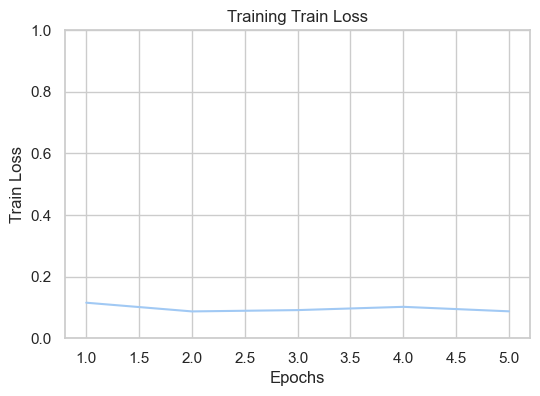

Standard Test


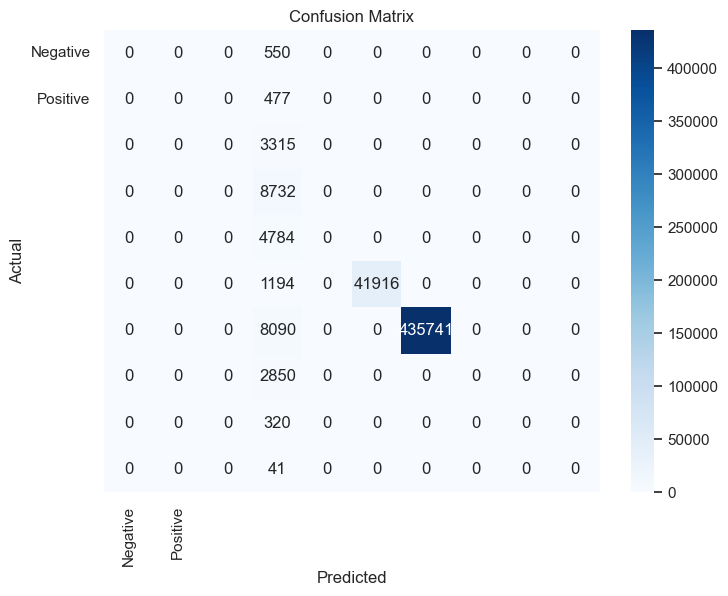

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/multi/tomeks01'
model1 = NNdynamicMulti(n_features, fc_size, device, save_dir)
sampler = 'tomeks'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.7
epochs = 5
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

In [41]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/02/multi/tomeks01/PB_epoch_{i}.pth"
    model1.load_model(path)
    print(f"Epoch: {i}")
    model1.test(test_loader)
    unique_classes = np.unique(y_test)
    preds = model1.test_predicted
    for cls in unique_classes:
        actual_class = y_test == cls
        predicted_class = preds == cls
        class_accuracy = np.sum(actual_class & predicted_class) / np.sum(actual_class)
        print(f"{cls}': {class_accuracy:.4f}")

c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 326.55batch/s]


Test Loss: 0.1190, Test Accuracy: 0.9562, Test F1: 0.9360
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.0000
4': 0.0000
5': 0.9723
6': 1.0000
7': 0.0000


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.0000
9': 0.0000
Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 334.99batch/s]


Test Loss: 0.1211, Test Accuracy: 0.9562, Test F1: 0.9360
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.0000
4': 0.0000
5': 0.9723
6': 1.0000
7': 0.0000


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.0000
9': 0.0000
Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 337.95batch/s]


Test Loss: 0.1169, Test Accuracy: 0.9572, Test F1: 0.9582
0': 0.0000
1': 0.0000
2': 0.0000
3': 1.0000
4': 0.0000
5': 0.9723
6': 0.9815
7': 0.0000


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.0000
9': 0.0000
Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 342.30batch/s]


Test Loss: 0.1188, Test Accuracy: 0.9562, Test F1: 0.9360
0': 0.0000
1': 0.0000
2': 0.0000
3': 0.0000
4': 0.0000
5': 0.9723
6': 1.0000
7': 0.0000


c:\Users\adi_s\Desktop\LSTM\Models\models.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


8': 0.0000
9': 0.0000
Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 340.70batch/s]


Test Loss: 0.1220, Test Accuracy: 0.9574, Test F1: 0.9584
0': 0.0000
1': 0.0000
2': 0.0000
3': 1.0000
4': 0.0000
5': 0.9723
6': 0.9818
7': 0.0000
8': 0.0000
9': 0.0000
